In [1]:
import numpy as np
import sklearn
from scipy.stats.stats import pearsonr
import pickle
import pandas as pd
from scipy.cluster.vq import whiten
from sklearn import cluster
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.pyplot as plt
import urllib
from numpy import isnan, nan, logical_not, logical_or
import tensorflow as tf
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from numpy import genfromtxt
from random import shuffle
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1810479891892622912
]


# Get the data

In [2]:
Count_full = np.array([22310,  3960,  3500,  1770,  3172,  3710,  2390,  1470,  1230,
        2150,  2380,  5722,  1924,  1920,  3532,  2600,  2264,  6910,
        6520,  4344,  1310,  1150,  2714,  2380,  2712,  6224,  2318,
        2636,  2646,  1410,  1410,  2950,  1410,  1100,  1240,  1310,
        1580,  1790,  1724,  2042,  1860,  1010,  1528,  5462,  5720,
        2778,  1408,  6330,  2040,  4960,  1660,  1570,  1450,  1090,
        4632,  1438,  1418,  3300,  1220,  3624,  1400,  1524,  1160,
        3486,  2030,  2200,  2694,  5750,  1522,  1950,  1280,  1910,  5834])

In [3]:
length_folders = np.array([10, 13, 20, 14, 16])

In [4]:
full_data_x = pickle.load(open("Full_data_x.p", "rb" ))
print(full_data_x.shape)
full_data_x = np.reshape(full_data_x, (full_data_x.shape[0],full_data_x.shape[1]*full_data_x.shape[2]))
print(full_data_x.shape)

(213072, 68, 2)
(213072, 136)


In [5]:
data_x = pickle.load( open( "data_x.p", "rb" ))
print(data_x.shape)

(106536, 196)


In [6]:
data_x_68 = pickle.load( open( "data_x_68.p", "rb" ))
print(data_x_68.shape)

(106536, 272)


In [7]:
annotation_vector_Two = pickle.load( open( "annotation_vector_Two.p", "rb" ))
print(annotation_vector_Two.shape)

(73,)


# Pre-processing (scaling the data and smoothing the label)

In [8]:
# get the participants separated

from sklearn import preprocessing

data_participant1 = data_x_68[:,:98]
data_participant2 = data_x_68[:,98:]
participant1_scaled = preprocessing.scale(data_participant1)
participant2_scaled = preprocessing.scale(data_participant2)
data_x_68 = preprocessing.scale(data_x_68)

C:\Users\pinouche\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype <U7 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [9]:
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

def SmoothResponse(response_list = annotation_vector_Two):
    length = len(annotation_vector_Two)
    gauss_kernel_40 = Gaussian1DKernel(25)
    gauss_kernel_50 = Gaussian1DKernel(50)
    gauss_kernel_75 = Gaussian1DKernel(75)
    gauss_kernel_100 = Gaussian1DKernel(100)
    annotation_RBF40 = []
    annotation_RBF50 = []
    annotation_RBF75 = []
    annotation_RBF100 = []
    for index in range(length):
        response_list[index] = np.reshape(response_list[index], (response_list[index].shape[0],))
        
        Ann40 = convolve(response_list[index], gauss_kernel_40)
        Ann40[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann40 = np.reshape(Ann40, (response_list[index].shape[0],1))
        
        Ann50 = convolve(response_list[index], gauss_kernel_50)
        Ann50[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann50 = np.reshape(Ann50, (response_list[index].shape[0],1))
        
        Ann75 = convolve(response_list[index], gauss_kernel_75)
        Ann75[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann75 = np.reshape(Ann75, (response_list[index].shape[0],1))
        
        Ann100 = convolve(response_list[index], gauss_kernel_100)
        Ann100[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann100 = np.reshape(Ann100, (response_list[index].shape[0],1))
    
        annotation_RBF40.append(Ann40)
        annotation_RBF50.append(Ann50)
        annotation_RBF75.append(Ann75)
        annotation_RBF100.append(Ann100)
           
    return annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 

In [10]:
def SmoothResponse2(response_list):
    length = len(response_list)
    gauss_kernel_40 = Gaussian1DKernel(25)
    gauss_kernel_100 = Gaussian1DKernel(100)
    annotation_RBF40 = []
    annotation_RBF100 = []
        
    response_list = np.reshape(response_list, (length,))
        
    Ann40 = convolve(response_list, gauss_kernel_40)
    Ann40[length-100:,] = response_list[length-100:]
        
    Ann100 = convolve(response_list, gauss_kernel_100)
    Ann100[length-100:,] = response_list[length-100:]
    
    annotation_RBF40.append(Ann40)
    annotation_RBF100.append(Ann100)
           
    return annotation_RBF40[0], annotation_RBF100[0]

In [11]:
annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 = SmoothResponse()

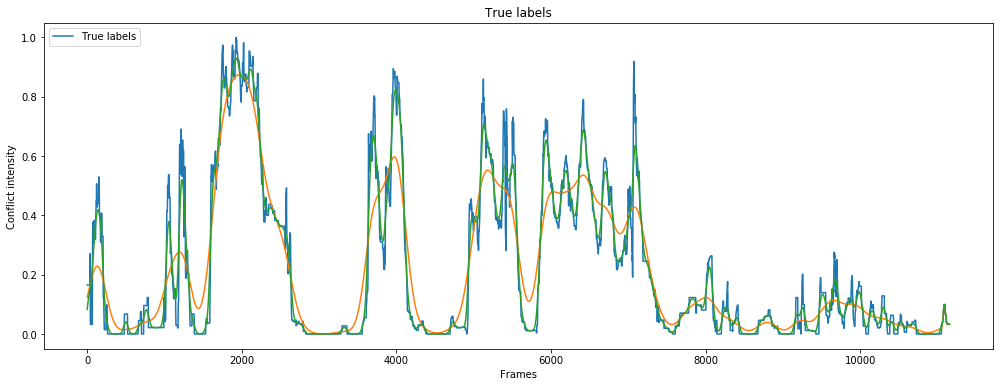

In [12]:
# Plot a few video sequences to see if smoothing is justified

fig = plt.figure(figsize=(17, 6))
plt.plot(annotation_vector_Two[0])
plt.plot(annotation_RBF100[0])
plt.plot(annotation_RBF40[0])
plt.title('True labels')
plt.ylabel('Conflict intensity')
plt.xlabel('Frames')
plt.legend(['True labels'], loc='upper left')
plt.show()

# Format the data to be fed in the LSTM

In [13]:
def Makelist(data,Count):
    Count = Count/2
    list_data = []
    ball = 0
    for index in range(0,len(Count)):
        list_data.append(data[ball:(ball+int(Count[index])),:])
        ball += int(Count[index])
    return(np.asarray(list_data))

In [14]:
list_data_x = Makelist(data_x_68, Count_full)

In [15]:
# put the things into FOLDS

def DoFOLDS(list_data, annotation_list_smooth, annotation_list, num_folder1=length_folders[0], num_folder2=length_folders[1], num_folder3=length_folders[2], num_folder4=length_folders[3], num_folder5=length_folders[4]):
    Fold1 = []
    Fold2 = []
    Fold3 = []
    Fold4 = []
    Fold5 = []
    Fold1_y_smooth = []
    Fold2_y_smooth = []
    Fold3_y_smooth = []
    Fold4_y_smooth = []
    Fold5_y_smooth = []
    Fold1_y = []
    Fold2_y = []
    Fold3_y = []
    Fold4_y = []
    Fold5_y = []
    
    for index in range(num_folder1):
        Fold1.append(list_data[index])
        Fold1_y_smooth.append(annotation_list_smooth[index])
        Fold1_y.append(annotation_list[index])
    for index in range(num_folder1, num_folder1+num_folder2):
        Fold2.append(list_data[index])
        Fold2_y_smooth.append(annotation_list_smooth[index])
        Fold2_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2,num_folder1+num_folder2+num_folder3):
        Fold3.append(list_data[index])
        Fold3_y_smooth.append(annotation_list_smooth[index])
        Fold3_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2+num_folder3,num_folder1+num_folder2+num_folder3+num_folder4):
        Fold4.append(list_data[index])
        Fold4_y.append(annotation_list[index])
        Fold4_y_smooth.append(annotation_list_smooth[index])
    for index in range(num_folder1+num_folder2+num_folder3+num_folder4,num_folder1+num_folder2+num_folder3+num_folder4+num_folder5):
        Fold5.append(list_data[index])
        Fold5_y_smooth.append(annotation_list_smooth[index])
        Fold5_y.append(annotation_list[index])
    
    assert (len(Fold1)+len(Fold2)+len(Fold3)+len(Fold4)+len(Fold5)) == 73
    
    return Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y

Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y = DoFOLDS(list_data_x, annotation_RBF40, annotation_vector_Two)

In [16]:
#Test number must be either 1,2,3,4,5

def MakeTrainValTest(test_number, Fold1=Fold1, Fold2=Fold2, Fold3=Fold3, Fold4=Fold4, Fold5=Fold5, Fold1_y=Fold1_y, Fold2_y=Fold2_y, Fold3_y=Fold3_y, Fold4_y=Fold4_y, Fold5_y=Fold5_y, Fold1_y_smooth=Fold1_y_smooth, Fold2_y_smooth=Fold2_y_smooth, Fold3_y_smooth=Fold3_y_smooth, Fold4_y_smooth=Fold4_y_smooth, Fold5_y_smooth=Fold5_y_smooth):
    list_Folds = list([Fold1, Fold2, Fold3, Fold4, Fold5])
    list_Folds_y = list([Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y])
    list_Folds_y_smooth = list([Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth])
    number_val_test = []
    Train_list = []
    Val_list = []
    Test_list = []
    Train_list_y = []
    Val_list_y = []
    Test_list_y = []
    length = 0
    
    Test_list = list_Folds[test_number-1]
    Test_list_y = list_Folds_y[test_number-1]
    number_val_test.append(test_number-1)
    
    if(test_number == 1):
        Val_list = list_Folds[4]
        Val_list_y = list_Folds_y[4]
        number_val_test.append(4)
    else:
        Val_list = list_Folds[test_number-2]
        Val_list_y = list_Folds_y[test_number-2]
        number_val_test.append(test_number-2)
    
    for index in range(5):
        length = len(list_Folds[index])
        if(index != number_val_test[0] and index != number_val_test[1]):
            for index2 in range(length):
                Train_list.append(list_Folds[index][index2])
                Train_list_y.append(list_Folds_y_smooth[index][index2])       
    
    return Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y 

In [17]:
Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y = MakeTrainValTest(1)

# Functions utilized

In [18]:
# function to compute the class accuracy

def ComputeAccuracy(True_classes_list, predicted_classes_list):
    accuracy = 0
    assert len(True_classes_list) == len(predicted_classes_list)
    for index in range(len(True_classes_list)):
        if(all (True_classes_list[index] == predicted_classes_list[index])):
            accuracy += 1
    accuracy /= len(predicted_classes_list)
    return(accuracy)

In [19]:
def PearsonCor(pred_val_list, val_list_y):
    pearson_cor = 0
    assert len(pred_val_list) == len(val_list_y)
    for index in range(len(pred_val_list)):
        pearson_cor += pearsonr(np.reshape(pred_val_list[index], (pred_val_list[index].shape[0],)), np.reshape(val_list_y[index], (val_list_y[index].shape[0],)))[0]
    return(pearson_cor/len(pred_val_list)) 

In [20]:
def ComputeCorr(pred, truth):
    result = pearsonr(pred, np.reshape(np.asarray(truth),(len(pred),)))
    return(result)

In [21]:
def CCC(pred, truth, pearson):
    result = (2*pearson*np.std(pred)*np.std(truth))/(np.std(pred)**2+np.std(truth)**2+(np.mean(pred)-np.mean(truth))**2)
    return(result)

In [22]:
def tfPearson(pred, truth):
    cov_xx = (1 / (tf.cast((tf.shape(pred)[0] - 1),tf.float32)) * tf.reduce_sum((pred - tf.reduce_mean(pred))**2))
    cov_yy = (1 / (tf.cast((tf.shape(pred)[0] - 1),tf.float32)) * tf.reduce_sum((truth - tf.reduce_mean(truth))**2))
    cov_xy = (1 / (tf.cast((tf.shape(pred)[0] - 1),tf.float32)) * tf.reduce_sum((pred - tf.reduce_mean(pred)) * (truth - tf.reduce_mean(truth))))
    tfPears = cov_xy/(tf.sqrt(cov_yy)*tf.sqrt(cov_xx))
    return cov_xx, cov_yy, cov_xy, tfPears

In [36]:
def tfCCC(pred, truth):
    cov_xx, cov_yy, cov_xy, tfPears = tfPearson(tf.cast(pred, tf.float32), tf.cast(truth, tf.float32))
    CCC = (2*tfPears*tf.sqrt(cov_xx)*tf.sqrt(cov_yy))/(tf.sqrt(cov_xx)**2+tf.sqrt(cov_yy)**2+(tf.reduce_mean(tf.cast(pred, tf.float32))-tf.reduce_mean(tf.cast(truth, tf.float32)))**2)
    return(-CCC)

In [24]:
def MSECov(pred, truth):
    cov_xy = (1 /(tf.cast((tf.shape(pred)[0] - 1),tf.float32)) * tf.reduce_sum((pred - tf.reduce_mean(pred)) * (truth - tf.reduce_mean(truth))))
    MSE = tf.cast(tf.losses.mean_squared_error(predictions = pred, labels = truth), tf.float32)
    loss = 0*MSE-cov_xy
    return(loss)

In [25]:
def epsilon_Loss2(labels, predictions, epsilon = 0.001, delta = 0.7, slope = 0.75):
    residual = tf.abs(labels-predictions)
    outcome_1 = tf.zeros(shape=(1,))
    outcome_2 = residual - epsilon
    outcome_3 = delta - epsilon + slope * residual
    result_2 = tf.cond(tf.reduce_mean(residual - epsilon) < delta, lambda: outcome_2, lambda: outcome_3)
    result = tf.cond(tf.reduce_mean(residual - epsilon) < 0, lambda: outcome_1, lambda: result_2)
    result = tf.reduce_mean(result)
    return(result)

In [26]:
# p must be smaller than num_element
def movingAvgTensor(tensor, p):
    length = tensor.get_shape()[1]
    num_element = tensor.get_shape()[0]
    z_tensor = tf.zeros([1, length])
    for index in range(num_element-p):
        #z_tensor[index,:] = tf.reduce_mean(tensor[index:index+p], 0)
        z_tensor = tf.concat([z_tensor, tf.reshape(tf.reduce_mean(tensor[index:index+p,:], 0), (1,length))], axis = 0)
    for index in range(num_element-p,num_element):
        #z_tensor[index,:] = tf.reduce_mean(tensor[index:length],0)
        z_tensor = tf.concat([z_tensor, tf.reshape(tf.reduce_mean(tensor[index:length,:],0), (1, length))], axis = 0)
    z_tensor = z_tensor[1:num_element+1,:]
    return(z_tensor)

In [27]:
def reverseTensor(tensor):
    length = tensor.get_shape()[1]
    num_element = tensor.get_shape()[0]
    z_tensor = tf.zeros([num_element, 1])
    for index in range(length):
        z_tensor = tf.concat([z_tensor, tf.reshape(tensor[:,length-index-1], (num_element, 1))], axis = 1)
    z_tensor = z_tensor[:,1:]
    return(z_tensor)

In [28]:
def Pooling(tensor, p):
    tensor_1 = movingAvgTensor(tensor, p)
    reversed_tensor = reverseTensor(tensor)
    tensor_2 = movingAvgTensor(reversed_tensor, p)
    final_tensor = tf.add(tensor_1, tensor_2)
    return(final_tensor)

In [29]:
def FixCCC(array,window_size):
    #if(len(np.unique(array)) == 1):
    rand_array = np.reshape(np.random.uniform(-0.02,0.02,window_size), (window_size,1))
    array += rand_array
    return(array)
    #else:
    #    return(array)      

In [30]:
def FixtfCCC(tensor, window_size):
    rand_tensor = tf.random_uniform(shape = (window_size,1), minval=-0.02, maxval = 0.02)
    new_tensor = tf.add(rand_tensor, tensor)
    return(new_tensor)

In [31]:
def ManyToOne(x_seq, y_seq, window_size, val_boolean):
    list_x = []
    list_y = []
    list_x_shuffled = []
    list_y_shuffled = []
    assert len(x_seq) == len(y_seq)
    lenght_new_seq = len(x_seq)-window_size+1
    
    for index in range(lenght_new_seq):
        list_x.append(x_seq[index:window_size+index,:])
        list_y.append(y_seq[window_size-1+index])
    
    if(val_boolean == 0):
        indices = list(range(lenght_new_seq))
        shuffle(indices)
    
        for element in indices:
            list_x_shuffled.append(list_x[element])
            list_y_shuffled.append(list_y[element])
            
    elif(val_boolean == 1):
        list_x_shuffled = list_x
        list_y_shuffled = list_y
        
    return list_x_shuffled, list_y_shuffled  

In [32]:
def ManyToMany(x_seq, y_seq, window_size, val_boolean):
    list_x = []
    list_y = []
    list_x_shuffled = []
    list_y_shuffled = []
    assert len(x_seq) == len(y_seq)
    lenght_new_seq = len(x_seq)-window_size+1
    
    for index in range(lenght_new_seq):
        list_x.append(x_seq[index:window_size+index,:])
        list_y.append(y_seq[index:window_size+index])
    
    if(val_boolean == 0):
        indices = list(range(lenght_new_seq))
        shuffle(indices)
    
        for element in indices:
            list_x_shuffled.append(list_x[element])
            list_y_shuffled.append(list_y[element])
            
    elif(val_boolean == 1):
        list_x_shuffled = list_x
        list_y_shuffled = list_y
        
    return list_x_shuffled, list_y_shuffled 

# Bidirectional LSTM encoder

In [33]:
timesteps_1 = 2
window_size = 25
p = 2
batch_size = window_size
n_epochs = 20
# Hidden layer for the LSTMs
hidden_size_bilstm = 136
hidden_size_mainlstm = 136

# Hidden size for the fully connected layer
FC1 = 64

alpha_value = window_size*2
num_input = 136
epsilon = 0.001
beta = 0.02
learning_rate = 0.000001

alpha_value = window_size

switch_loss = 0 #(number of epoch at which loss is switch from MSE to epsilon)
MC_samples = 12

In [34]:
def BidirectionalLSTM(train_x, train_y, val_x, val_y,hidden_size_bilstm=hidden_size_bilstm, hidden_size_mainlstm=hidden_size_mainlstm, batch_size = batch_size,  n_epochs=n_epochs, epsilon = epsilon, learning_rate=learning_rate):
    
    
    with tf.variable_scope('data'):
        alpha = tf.placeholder_with_default(1.0, shape=())
        prob = tf.placeholder_with_default(1.0, shape=())
        loss_bool = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [window_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")

    #Bidirectional lstm with different weights
    #with tf.variable_scope('lstm_cell_forward'):
    #    lstm_cell_f = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias= 1.0)
    #with tf.variable_scope('lstm_cell_backward'):
    #    lstm_cell_b = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias = 1.0)
     
    #Bidirectional lstm with shared weights (makes more sense for them to be shared)
    with tf.variable_scope('lstm_cell_bidirectional'):
        lstm_cell_f = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias= 1.0)
    with tf.variable_scope('lstm_cell_bidirectional', reuse=True):
        lstm_cell_b = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias = 1.0)
     
    with tf.variable_scope("lstm_bidirectional"):
        bi_outputs, _, _ = tf.nn.static_bidirectional_rnn(lstm_cell_f, lstm_cell_b, inputs = X, dtype= tf.float32)
        last_output = bi_outputs[-1]
        
        
        batch_mean2, batch_var2 = tf.nn.moments(last_output,[0])
        scale2 = tf.Variable(tf.ones([hidden_size_bilstm*2]))
        beta2 = tf.Variable(tf.zeros([hidden_size_bilstm*2]))
        BN2 = tf.nn.batch_normalization(last_output,batch_mean2, batch_var2, beta2, scale2, epsilon) 
        BN2 = tf.nn.dropout(BN2, prob, noise_shape=[1,hidden_size_bilstm*2])
        pooled_BN2 = Pooling(BN2, p)
        
        pooled_BN2 = tf.reshape(pooled_BN2, (1, window_size, hidden_size_bilstm*2))
        pooled_BN2 = tf.transpose(pooled_BN2, [1, 0, 2])
        pooled_BN2 = tf.unstack(pooled_BN2)
    
    with tf.variable_scope('lstm_cell_2'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size_mainlstm, hidden_size_mainlstm]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs2, lstm_state2 =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=pooled_BN2,dtype=tf.float32)
        lstm_outputs2 = tf.stack(tf.squeeze(lstm_outputs2))
        
        batch_mean3, batch_var3 = tf.nn.moments(lstm_outputs2,[0])
        scale3 = tf.Variable(tf.ones([hidden_size_mainlstm]))
        beta3 = tf.Variable(tf.zeros([hidden_size_mainlstm]))
        BN3 = tf.nn.batch_normalization(lstm_outputs2,batch_mean3, batch_var3, beta3, scale3, epsilon) 
        BN3 = tf.nn.dropout(BN3, prob, noise_shape=[1,hidden_size_mainlstm])
        
        
    with tf.variable_scope('Fully_connected_Layer1'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size_mainlstm, FC1], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.matmul(BN3, W_hidden)
        
        batch_mean4, batch_var4 = tf.nn.moments(hidden_relu,[0])
        scale4 = tf.Variable(tf.ones([FC1]))
        beta4 = tf.Variable(tf.zeros([FC1]))
        BN4 = tf.nn.batch_normalization(hidden_relu,batch_mean4, batch_var4, beta4, scale4, epsilon)
        BN4 = tf.nn.relu(BN4, name = "ReLu_hidden_layer")
        BN4 = tf.nn.dropout(BN4, prob, noise_shape=[1,FC1])
         
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [FC1, 1], stddev = 0.1), name = "linear_layer", trainable = True)
        logits_all = tf.matmul(BN4, W_hidden2)
        print(logits_all.get_shape())
        logits_all = FixtfCCC(logits_all, window_size)
        print(logits_all.get_shape())
        #logit_main = logits_all[window_size-1]
        
        logits_others = logits_all[:window_size-1,:]
        logits_all =  tf.reshape(logits_all, (1,window_size))
        W_all = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "linear_others", trainable = True)
        logit_main = tf.matmul(logits_all,W_all)
        

        # 3) epsilon-insensitive loss and MSE loss version 1
        
        rangetensor = tf.reshape(tf.range(1, window_size, delta=1, dtype=None, name='range'), (window_size-1,1))
        
        loss =  tf.cond(tf.equal(loss_bool, 1.0), lambda: epsilon_Loss2(labels = y[:window_size-1], predictions = logits_others), lambda: tf.reduce_mean(tf.losses.mean_squared_error(predictions = logits_others, labels = y[:window_size-1], weights = rangetensor)))
        loss_main = tf.reduce_mean(tf.losses.mean_squared_error(predictions = logit_main, labels = y[window_size-1:]))
        loss += alpha * loss_main
        #loss_cov = MSECov(tf.concat([logits_others,logit_main], axis = 0), y)
        #_,_,_,loss_cc = tfPearson(tf.concat([logits_others,logit_main], axis = 0), y)
        #loss += loss_cov
        #loss -= loss_cc
        loss_tf = tfCCC(tf.concat([logits_others,logit_main], axis = 0), y)
        loss += loss_tf
        #loss += alpha * loss_main
        
        
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if ("bias_hidden2" not in tf_var.name))
        loss += tf.cast(l2, dtype = tf.float32)

    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    #saver = tf.train.Saver()
    writer = tf.summary.FileWriter('./graphs/LSTM', sess.graph)
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    train_loss_list = []
    for i in range(1, n_epochs+1):
        if(i < switch_loss):
            loss_boolean = 0.0
        else:
            loss_boolean = 1.0
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (window_size, 2, num_input))
                Y_batch = FixCCC(np.reshape(list_y[index], (window_size,1)), window_size)
                
                _, Loss = sess.run([train_op, loss], feed_dict = {X_or: X_batch, y: Y_batch, alpha: window_size, loss_bool: loss_boolean, prob: 0.7})

                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
              
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = np.reshape(list_x_val[index1], (window_size, 2, num_input))
                    Y_batch = FixCCC(np.reshape(list_y_val[index1], (window_size,1)), window_size)
                    loss_batch, logits_batch = sess.run([loss, logit_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: window_size, loss_bool: loss_boolean, prob: 1})
                    
                    pred_val.append(logits_batch[0])
                    list_list_val_y.append(Y_batch[window_size-1])
                
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)
   
            main_sum_loss =  sum(loss_main_list)/len(val_x)

            # Compute the key metrics
        
            pearson = pearsonr(np.reshape(np.asarray(pred_val), (len(pred_val),)), np.reshape(np.asarray(list_list_val_y),(len(pred_val),)))
            Val_RBF25, Val_RBF100 = SmoothResponse2(pred_val) 
            corr25 = ComputeCorr(Val_RBF25, list_list_val_y)
            corr100 = ComputeCorr(Val_RBF100, list_list_val_y)
            CCC25 = CCC(Val_RBF25, list_list_val_y, corr25[0])
            CCC100 = CCC(Val_RBF100, list_list_val_y, corr100[0])
            CCCraw = CCC(pred_val, list_list_val_y, pearson[0])
            
            print("Step: " + str(i) + ": CCC val loss is " + str(main_sum_loss)+ " CCC training loss " + str(train_loss_sum))
            print("The pearson coefficient is: " + str(pearson) + ". The CCC is: " + str(CCCraw))
            print("For RBF25, the pearson coefficient is: " + str(corr25)+ ". The CCC is: " + str(CCC25))
            print("For RBF100, the pearson coefficient is: " + str(corr100)+ ". The CCC is: " + str(CCC100))
            
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))
     
    writer.close()    
    sess.close()
    tf.reset_default_graph()
    return lowest_loss, min_index, val_loss, train_loss_list, pred_val, list_list_val_y

In [35]:
# RUN THE ABOVE

#lowest_loss_list = []

#for index in range(5):
#    Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y = MakeTrainValTest(index+1)
#    lowest_loss, min_index, loss, predictions_val, predictions_train = NeuralNetMethod1(Train_list, Train_list_y, Val_list, Val_list_y, 0.0001, 196,64, 16)
#    lowest_loss_list.append(lowest_loss)

lowest_loss, min_index, val_loss, train_loss_list, pred_val_mean, list_list_val_y = BidirectionalLSTM(Train_list, Train_list_y, Val_list, Val_list_y)

(25, 1)
(25, 1)
Epoch 1 done.
Step: 1: CCC val loss is 22.7612316568 CCC training loss 26.9099964428
The pearson coefficient is: (0.0058159447900380445, 0.41014062163224307). The CCC is: 0.00499132837953
For RBF25, the pearson coefficient is: (0.019368116462904397, 0.006085836675592626). The CCC is: 0.00833279384922
For RBF100, the pearson coefficient is: (0.048096637060712398, 9.4088966903740872e-12). The CCC is: 0.015297853993
Epoch 2 done.
Step: 2: CCC val loss is 21.0386264671 CCC training loss 22.5159072534
The pearson coefficient is: (0.018764289331764571, 0.0078702829095140224). The CCC is: 0.0128465768325
For RBF25, the pearson coefficient is: (0.056591434997906809, 1.0509106508645312e-15). The CCC is: 0.0162941704897
For RBF100, the pearson coefficient is: (0.10347212341962195, 7.1574476604425651e-49). The CCC is: 0.0217817835654
Epoch 3 done.
Step: 3: CCC val loss is 20.7846505495 CCC training loss 21.5614075609
The pearson coefficient is: (0.071841204211757548, 2.26343525158

In [110]:
tf.reset_default_graph()

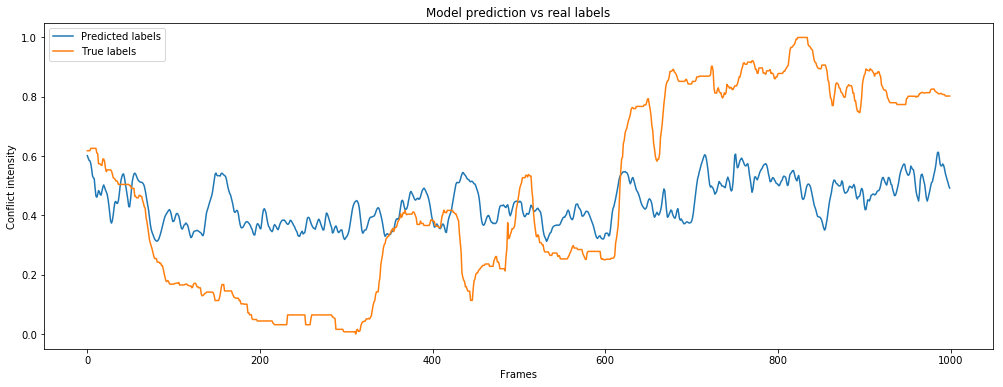

In [48]:
# function to plot true vs predicted

def plotTrueVPred(true_values, predicted_values):
    fig = plt.figure(figsize=(17, 6))
    plt.plot(predicted_values)
    plt.plot(true_values)
    plt.title('Model prediction vs real labels')
    plt.ylabel('Conflict intensity')
    plt.xlabel('Frames')
    plt.legend(['Predicted labels', 'True labels'], loc='upper left')
    plt.show()
    #fig.savefig('newfiguseless.png', bbox_inches='tight')
    
plotTrueVPred(list_list_val_y[3000:4000],pred_val_mean[3000:4000])